# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
#Imports here
import numpy as np
from glob import glob
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from tqdm import tqdm
import cv2      
from PIL import Image
import matplotlib.pyplot as plt                        
%matplotlib inline   

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


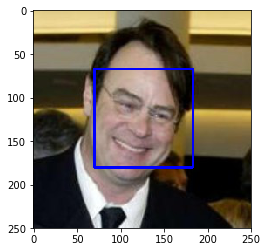

In [3]:

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
h_count = 0
dh_count = 0
for i in human_files_short:
    if face_detector(i):
        h_count += 1
for e in dog_files_short:
    if face_detector(e):
        dh_count += 1
print("percentage of human face detected in first 100 images of human_files: " + str(h_count))
print("percentage of human face detected in first 100 images of dog_files: " + str(dh_count))

percentage of human face detected in first 100 images of human_files: 98
percentage of human face detected in first 100 images of dog_files: 17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 119046590.31it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:

import torchvision.transforms as transforms
from torch.autograd import Variable
img_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    img = Image.open(img_path)
    img = img_transform(img).float()
    img = Variable(img, requires_grad=True)
    img = img.unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    return VGG16(img) # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predict = VGG16_predict(img_path)
    pred = torch.max(predict,1)[1].item()
    #print(pred)
    return pred>=151 and pred<=268 # true/false

In [9]:
print(dog_detector('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg'))
print(dog_detector(dog_files_short[22]))

True
True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
files_short  = zip(human_files_short,dog_files_short)
hd_count = 0
d_count = 0
for h_files, d_files in files_short:
    hd_count += dog_detector(h_files)
    d_count += dog_detector(d_files)
print("percentage of dogs detected in first 100 images of human_files: " + str(hd_count))
print("percentage of dogs detected in first 100 images of dog_files: " + str(d_count))

percentage of dogs detected in first 100 images of human_files: 0
percentage of dogs detected in first 100 images of dog_files: 100


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = '/data/dog_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [12]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(valid_dir, transform = val_transform)
test_data = datasets.ImageFolder(test_dir, transform = test_transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(val_data, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

loader = {'train':trainloader,'valid':validloader,'test':testloader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: I have resized the images using RandomResizedCrop for the trainng set and CenterCrop for the validation and test sets. the images have been cropped to 224, which is considered to be standard for various pre-trained models. So to make my cnn aligned with those models I have chisen for it to be of 224 in size.

I have augumented the dataset in training set using RandomRotation, horizontal flip and vertical flip.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.conv4 = nn.Conv2d(64,128,3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128,256,3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 133)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten image input
        #print(x.shape)
        x = x.view(-1, 256 * 7* 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ This architecture consists of 5 convolutional layers followed by 2 linear layers at the end. Throughout all the convolutional layers the x-y dimension of the input image remains the same, and only reduces when passing through the pooling layers wih kernel size 2x2 and stride of 2.

I have also added Batch Normalization and dropout of 0.25 to improve the speed and to reduce the regularization 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [16]:
import torch.optim as optim

### TODO: select loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer= optim.SGD(model_scratch.parameters(), lr = 0.06)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    steps = 0
    valid_loss_min = np.Inf
    total = 0
    correct = 0

    # change to cuda
    model.to('cuda')
    validation_loss = 0
    for e in range(n_epochs):
        training_loss = 0
        model.train()
        for ii, (inputs, labels) in enumerate(loaders['train']):
            steps += 1

            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()*inputs.size(0)


        model.eval()
        for ii, (inputs, labels) in enumerate(loaders['valid']):

            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            validation_loss += loss.item()*inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            lrsheduler.step(validation_loss)

        training_loss = training_loss/len(trainloader.dataset)
        validation_loss = validation_loss/len(validloader.dataset)
        _correct = (correct*100)/total



        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.6f}'.format(
            e, training_loss, validation_loss, _correct))

        if validation_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            validation_loss))

        #to save the check-points

            torch.save(model.state_dict(), save_path)
            valid_loss_min = validation_loss
            
    # return trained model
    return model




# train the model


In [19]:
model_scratch = train(20, loader, model_scratch, optimizer, 
                      criterion, use_cuda, 'model_scratch_2.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch_2.pt'))

Epoch: 0 	Training Loss: 4.838367 	Validation Loss: 4.705206 	Accuracy: 2.754491
Validation loss decreased (inf --> 4.705206).  Saving model ...
Epoch: 1 	Training Loss: 4.677813 	Validation Loss: 4.613127 	Accuracy: 2.994012
Validation loss decreased (4.705206 --> 4.613127).  Saving model ...
Epoch: 2 	Training Loss: 4.567678 	Validation Loss: 4.501273 	Accuracy: 3.193613
Validation loss decreased (4.613127 --> 4.501273).  Saving model ...
Epoch: 3 	Training Loss: 4.495986 	Validation Loss: 4.787557 	Accuracy: 3.113772
Epoch: 4 	Training Loss: 4.449037 	Validation Loss: 4.655930 	Accuracy: 3.089820
Epoch: 5 	Training Loss: 4.404029 	Validation Loss: 4.230919 	Accuracy: 3.373253
Validation loss decreased (4.501273 --> 4.230919).  Saving model ...
Epoch: 6 	Training Loss: 4.339308 	Validation Loss: 4.353298 	Accuracy: 3.490163
Epoch: 7 	Training Loss: 4.283657 	Validation Loss: 4.264400 	Accuracy: 3.712575
Epoch: 8 	Training Loss: 4.240233 	Validation Loss: 4.359153 	Accuracy: 3.885562


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [17]:
model = Net()
model.load_state_dict(torch.load('model_scratch_1.pt'))
model.eval()
if use_cuda:
    model.cuda()

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loader, model, criterion, use_cuda)

Test Loss: 3.189121


Test Accuracy: 21% (183/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [7]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet152(pretrained=True)

# check if CUDA is available
print(model_transfer)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 98615075.73it/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [20]:
"""ly = 0
for param in resnet152.parameters():
    if ly <= 25:
        param.requires_grad = False
        ly += 1
    else:
        param.requires_grad = True"""
"""        
child_counter = 0
for child in resnet152.children():
   if child_counter < 10:
      #print("child ",child_counter," was frozen")
      for param in child.parameters():
          param.requires_grad = False
   else:
      #print("child ",child_counter," was not frozen")
      child_counter += 1
"""
for param in model_transfer.parameters():
    param.requires_grad = False

In [22]:
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          #('adaptive_pool',nn.AdaptiveAvgPool2d((1,1))),
                          #('adaptive_maxpool',nn.AdaptiveMaxPool2d((1,1))),
                          #('flatten',nn.Flatten()),
                          ('batch_norm',nn.BatchNorm1d(2048,eps=1e-05, momentum=0.1, affine=True)),
                          ('Dropout',nn.Dropout(0)),
                          ('fc1', nn.Linear(2048, 520)),
                          ('activation', nn.ReLU()),
                          ('fc2', nn.Linear(520, 133)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model_transfer.fc = classifier
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [23]:
# move model to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  The architecture I used for this problem was renet152, it's one of the architecture with least errors on the ImageNet dataset. After freezing the feature extractor part of the network I have redifined the linear Layers of the network, adding Bathch_norm(1d) and making it a fully connected layers with 2 linear layers.
Since the dataset we have is comparitively small and similar to the dataset of ImageNet, I have decided to take this approach.

Also I have chosen the final output to be a log softmax layer using negativeLogLikelyhoodLoss as the criterion for the Loss function.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [24]:
from torch.optim import lr_scheduler

criterion_t = nn.NLLLoss()
optimizer_t = optim.Adam(model_transfer.fc.parameters(), lr=0.0003)
lrsheduler = lr_scheduler.StepLR(optimizer_t, step_size=4, gamma=0.1)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [25]:
# train the model
model_transfer = train(10, loader, model_transfer, optimizer_t, criterion_t, use_cuda, 'model_transfer_8.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 0 	Training Loss: 3.630136 	Validation Loss: 1.342590 	Accuracy: 66.706587
Validation loss decreased (inf --> 1.342590).  Saving model ...
Epoch: 1 	Training Loss: 2.412067 	Validation Loss: 1.373809 	Accuracy: 65.449102
Epoch: 2 	Training Loss: 2.406825 	Validation Loss: 1.356412 	Accuracy: 65.429142
Epoch: 3 	Training Loss: 2.403316 	Validation Loss: 1.354716 	Accuracy: 65.389222
Epoch: 4 	Training Loss: 2.407732 	Validation Loss: 1.348826 	Accuracy: 65.461078
Epoch: 5 	Training Loss: 2.380738 	Validation Loss: 1.350036 	Accuracy: 65.608782
Epoch: 6 	Training Loss: 2.411452 	Validation Loss: 1.364915 	Accuracy: 65.611634
Epoch: 7 	Training Loss: 2.384686 	Validation Loss: 1.360440 	Accuracy: 65.553892
Epoch: 8 	Training Loss: 2.409901 	Validation Loss: 1.357315 	Accuracy: 65.522289
Epoch: 9 	Training Loss: 2.434169 	Validation Loss: 1.375046 	Accuracy: 65.389222


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [26]:
test(loader, model_transfer, criterion_t, use_cuda)

Test Loss: 1.393890


Test Accuracy: 66% (556/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [27]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loader['train'].dataset.classes]


"""img_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])"""

def predict_breed_transfer(img_path):
    img_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    # load the image and return the predicted breed
    img = Image.open(img_path)
    img = img_transform(img).float()
    img = Variable(img, requires_grad=True)
    img = img.unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    
    pred = model_transfer(img)
    predict = torch.max(pred,1)[1].item()
    return class_names[predict]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [30]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if face_detector(img_path):
        print("A Human has been detected")
        print("the resembling dog breed is " + predict_breed_transfer(img_path))
    elif dog_detector(img_path):
        print("A dog has been detected")
        dog_pred = predict_breed_transfer(img_path)
        print("A dog is detected in the image with breed " + dog_pred)
    else:
        print("please provide appropriate input image, either a dog or a human")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The model performs as expected, but could've been much better than 66% test accuracy.

Possible points for Improvements:

1)Exposing the model to more data for training, and further increasing the accuracy by using more data augmentation techniques.

2)Choosing and trying more different pre-trained model for transfer learning and checking for which has more better accuracy.

3)Trying more different optimization algorithms and fine tuning other hyperparameters for the algorithm.

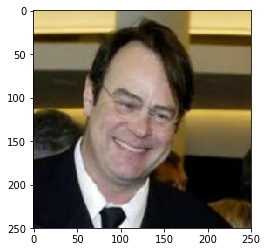

A Human has been detected
the resembling dog breed is Chinese crested


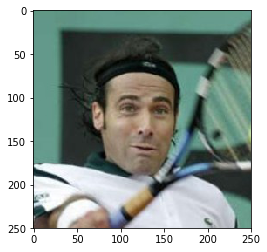

A Human has been detected
the resembling dog breed is Basenji


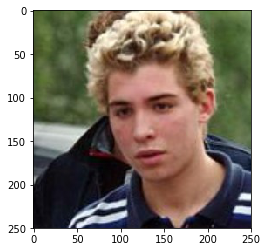

A Human has been detected
the resembling dog breed is Irish wolfhound


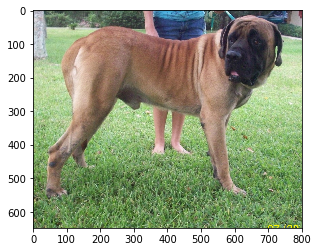

A dog has been detected
A dog is detected in the image with breed Bullmastiff


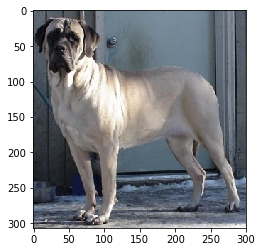

A dog has been detected
A dog is detected in the image with breed Bullmastiff


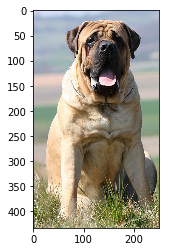

A dog has been detected
A dog is detected in the image with breed Bullmastiff


In [31]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

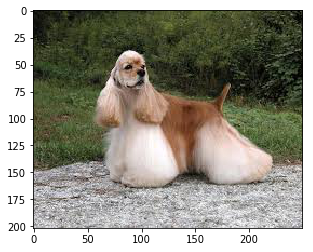

A dog has been detected
A dog is detected in the image with breed Clumber spaniel


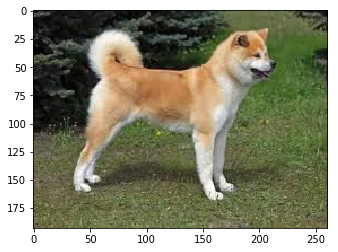

A dog has been detected
A dog is detected in the image with breed Pembroke welsh corgi


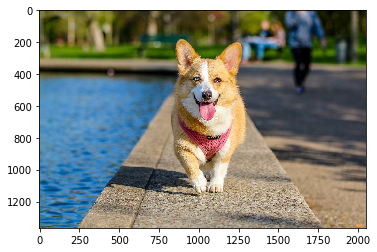

A Human has been detected
the resembling dog breed is Pembroke welsh corgi


In [41]:
d_images = np.array(glob("images/updogfolder/*"))
for file_ in d_images:
    run_app(file_)

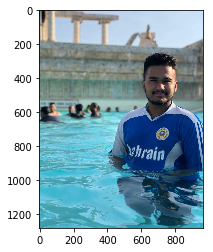

A Human has been detected
the resembling dog breed is Pharaoh hound


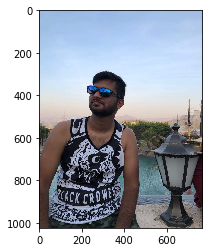

please provide appropriate input image, either a dog or a human


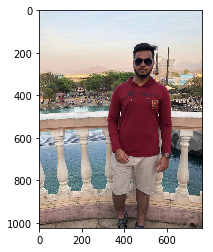

A Human has been detected
the resembling dog breed is Cane corso


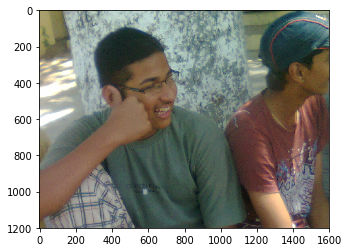

please provide appropriate input image, either a dog or a human


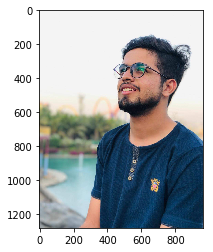

A Human has been detected
the resembling dog breed is Basenji


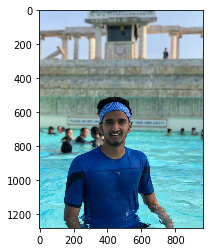

A Human has been detected
the resembling dog breed is Basenji


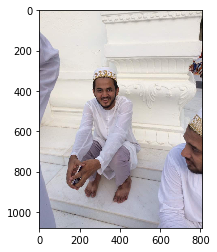

A Human has been detected
the resembling dog breed is Bulldog


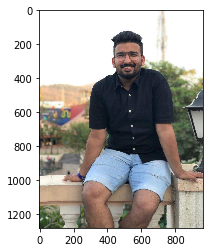

A Human has been detected
the resembling dog breed is Chihuahua


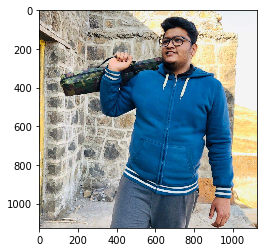

A Human has been detected
the resembling dog breed is Cane corso


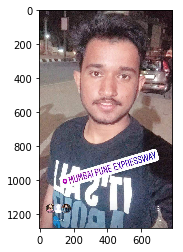

A Human has been detected
the resembling dog breed is Lakeland terrier


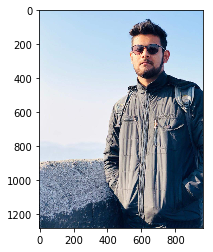

A Human has been detected
the resembling dog breed is Smooth fox terrier


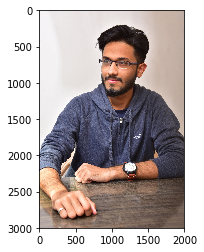

A Human has been detected
the resembling dog breed is Basenji


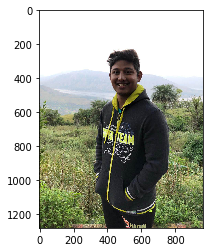

A Human has been detected
the resembling dog breed is Cane corso


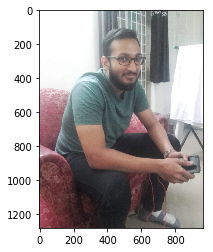

A Human has been detected
the resembling dog breed is Chinese crested


In [42]:
#images of my friends
h_images = np.array(glob("images/human_images/*"))
for file_ in h_images:
    run_app(file_)